In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns
from sklearn.metrics import mean_absolute_error as mape

# Configurações iniciais
np.random.seed(42)
current_date = pd.to_datetime('2024-07-01')
date_rng = pd.date_range(start='2020-01-01', end=current_date, freq='M')

# Criando uma série temporal com tendência e sazonalidade para y
trend = np.linspace(100, 200, len(date_rng))
seasonal = 10 * np.sin(2 * np.pi * date_rng.month / 12)
y = trend + seasonal + np.random.normal(scale=5, size=len(date_rng))

# Gerando dados para SELIC (simplificação, variação aleatória em torno de um valor base)
selic_base = 5
selic = selic_base + np.random.normal(scale=0.5, size=len(date_rng))

# Gerando dados para IPCA (simplificação, variação aleatória em torno de um valor base)
ipca_base = 3
ipca = ipca_base + np.random.normal(scale=0.2, size=len(date_rng))

# Criando o DataFrame com as colunas 'ds' e 'unique_id'
df = pd.DataFrame(data={'ds': date_rng, 'unique_id': 'H1', 'y': y, 'selic': selic, 'ipca': ipca})

In [2]:
df.head()

,ds,unique_id,y,selic,ipca
0,2020-01-31,H1,107.483571,5.515500,3.051510
1,2020-02-29,H1,109.855725,5.465640,2.985111
2,2020-03-31,H1,117.012028,4.580391,2.616246
3,2020-04-30,H1,121.935781,4.845394,2.994697
4,2020-05-31,H1,111.376403,5.165632,3.012046


In [9]:
import lightgbm as lgb
import pandas as pd
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.utils import generate_daily_series, generate_prices_for_series
from mlforecast.target_transforms import Differences


In [6]:
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

In [7]:
models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

In [10]:
fcst = MLForecast(
    models=models,
    freq='M',
    lags=[1, 3],
    #lag_transforms={
     #   1: [ExpandingMean()],
      #  7: [RollingMean(window_size=28)]
    #},
    target_transforms=[Differences([1, 12])],
)

In [11]:
target = 'y'

MLForecast(models=[LGBMRegressor, LinearRegression], freq=M, lag_features=['lag1', 'lag12', 'lag3'], date_features=[], num_threads=1)

In [60]:
def predicted_plot(df, true, predicted, mape):
    df = df.copy()
    df['ds'] = (pd.to_datetime(df['ds']) - pd.DateOffset(days=27))

    plt.figure(figsize=(12, 6))

    sns.lineplot(x='ds', y=true, data=df, marker='o', label='Valores Reais', color='blue')
    sns.lineplot(x='ds', y=predicted, data=df, marker='o', label='Valores Preditos', color='red')

    plt.xlabel('Data')
    plt.ylabel('Valores')
    plt.title('Valores Reais vs Valores Preditos ao Longo do Tempo')

    plt.text(0.98, 0.02, f'MAPE: {mape:.2f}%',
             fontsize=12, color='black',
             verticalalignment='bottom', horizontalalignment='right',
             transform=plt.gca().transAxes)
    plt.legend()


    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()

    plt.show()

In [61]:
def back_test(df, modelo, target):
  years = [2022, 2023]
  for year in years:
    train_end = pd.Timestamp(f'{year}-09-30')
    max_test = train_end + pd.DateOffset(months=16)
    test = df.query(f"(ds > '{train_end}') & (ds <= '{max_test}')")
    train = df.query(f"ds <= '{train_end}'")


    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)

    modelo.fit(train, static_features=[])
    print('MODELO AJUSTADO')


    preds = fcst.predict(h=X_test.shape[0], X_df=X_test)

    preds = preds.merge(test[[target, 'ds']], on='ds')

    next_year = year + 1
    preds_next_year = preds[preds['ds'].dt.year == next_year]

    print('ate aqui foi')
    mape_calculado = mape(preds_next_year[target], preds_next_year['LGBMRegressor'])
    print(f" -- MAPE: {year}: {mape_calculado:.2f}% --")
    predicted_plot(preds_next_year, target, 'LGBMRegressor', mape_calculado)


MODELO AJUSTADO
ate aqui foi
 -- MAPE: 2022: 8.69% --


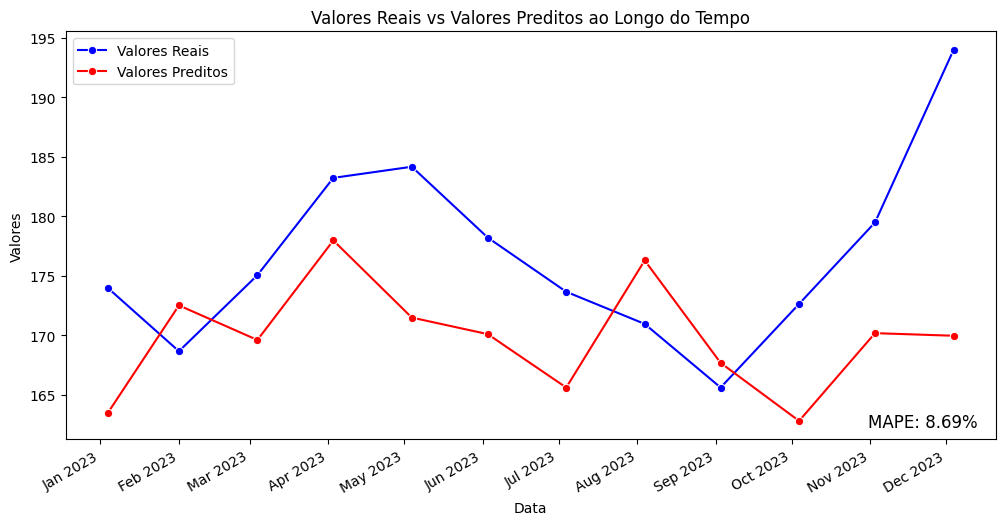

MODELO AJUSTADO
ate aqui foi
 -- MAPE: 2023: 7.19% --


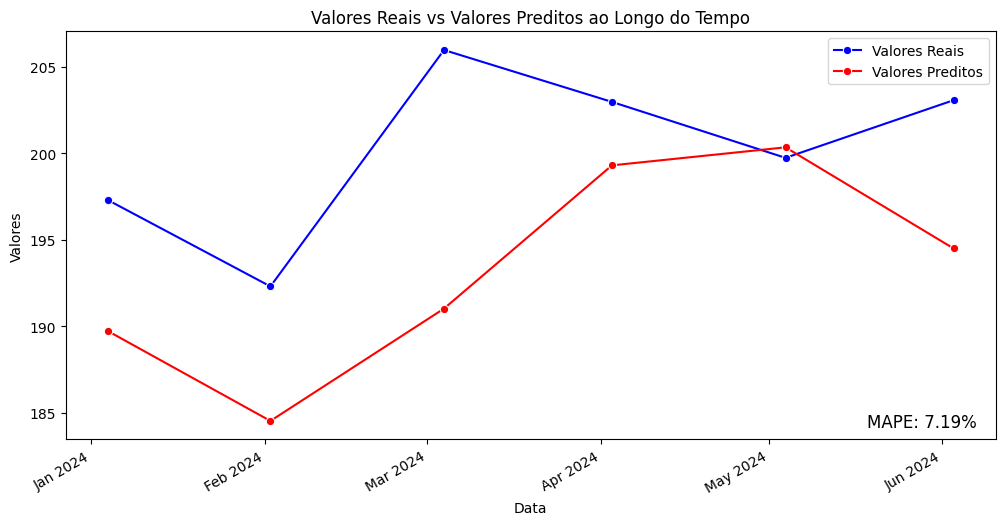

In [62]:
back_test(df, fcst, target)

In [ ]:
fcst.get_missing_future(h=3, X_df=X_test)

,unique_id,ds
0,H1,2023-09-30
1,H1,2023-10-31
2,H1,2023-11-30
